In [1]:
pip install python-sat

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from itertools import combinations
from pysat.formula import CNF
from pysat.solvers import Glucose3
import matplotlib.pyplot as plt

In [57]:
BG_GREEN = '\x1b[42m'
BG_RED = '\x1b[41m'
TEXT_WHITE='\x1b[0m'
RESET = '\x1b[0m'

[DISPLAY BY CONSOLE WITH ANSI ESCAPE COLOR CODE]
  2 3     0         
        3   2     6 
    5   5 3   5 7 4 
  4   5   5   6   3 
    4   5   6     3 
      2   5         
4   1       1 1     
4   1       1   4   
        6         4 
  4 4     5   4     


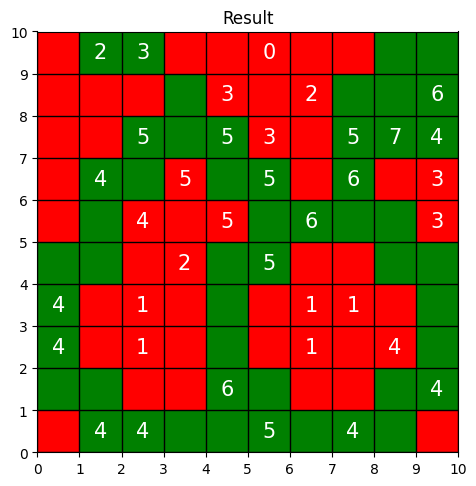

In [77]:
class Board:
    def __init__(self, matrix):
        self.matrix = matrix
        self.rows = len(matrix)
        self.cols = len(matrix[0])
   
        """ 
        Assign each cell with a unique propositional variable ID 
        the matrix so that it can be used in SAT solvers.
        """
        self.var = {}
        vid = 1
        for r in range(self.rows):
            for c in range(self.cols):
                self.var[(r,c)] = vid
                vid += 1

    
    """ 
    Find all neighbors (Include itself) by iterate in: 
        Vertical offset: 
            -1: Up
             0: Center (Itself)
            +1: Down 
        Horizontal offset: 
            -1: Left
             0: Center (Itself)
            +1: Right 
            
    Example: 
        Give a 3x3 matrix, each cell consists of a non-negative integer.
        Select cell(0,0) to find its neighbors.
            dr = -1; 
                dc = -1: (-1, -1) --> r < 0; c < 0 --> invalid --> Skip
                dc =  0: (-1,  0) --> r < 0        --> invalid --> Skip
                dc = +1: (-1, +1) --> r < 0        --> invalid --> Skip
            dr = 0;
                dc = -1: ( 0, -1) --> c < 0        --> invalid --> Skip
                dc =  0: ( 0,  0) -->              --> valid   --> Yield
                dc = +1: ( 0, +1) -->              --> valid   --> Yield 
            dr = 1:
                dc = -1: ( 1, -1) --> c < 0        --> invalid --> Skip
                dc =  0: ( 1,  0) -->              --> valid   --> Yield
                dc = +1: ( 1, +1) -->              --> valid   --> Yield                          
    """
    def neighbors(self, r, c):
        for dr in (-1, 0, 1):
            for dc in (-1, 0, 1):
                rr, cc = r+dr, c+dc
                if 0 <= rr < self.rows and 0 <= cc < self.cols:
                    yield self.var[(rr, cc)]         

    """
    Translates the numeric grid constraints into CNF clauses
    """
    def encode(self):
        cnf = CNF()
    
        for r in range(self.rows):
            for c in range(self.cols):
                val = self.matrix[r][c]
                if val is None:
                    continue
                
                # print(f"cel[{r}][{c}]: {val}")
                lits = list(self.neighbors(r, c))
                k = val
                n = len(lits)
                
                for combo in combinations(lits, k+1):
                    cnf.append([-v for v in combo])
                
                for combo in combinations(lits, n-k+1):
                    cnf.append(list(combo))
        return cnf

    def solve(self):
        cnf = self.encode()
        solver = Glucose3()
        solver.append_formula(cnf)
        sat = solver.solve()
        
        if not sat:
            print("No solution found.")
            return None
        
        model = solver.get_model()
        assignment = {}
        
        for (r, c), vid in self.var.items():
            assignment[(r, c)] = (model[vid-1] > 0)
        return assignment

    def console_display(self, assignment):
        print("[DISPLAY BY CONSOLE WITH ANSI ESCAPE COLOR CODE]")
        for r in range(self.rows):
            row_str = ''
            for c in range(self.cols):
                val = assignment[(r, c)]
                bg = BG_GREEN if val else BG_RED
                ch = ' ' if self.matrix[r][c] is None else str(self.matrix[r][c])
                row_str += f"{bg}{ch} {RESET}"
            print(row_str)
            
    def plt_display(self, assignment):
        fig, ax = plt.subplots()
        
    
        ax.set_xticks(range(self.cols + 1))
        ax.set_yticks(range(self.rows + 1))

        ax.grid(True, which='both', color='black', linewidth=1)

        # ax.set_xticklabels([])
        # ax.set_yticklabels([])

        for r in range(self.rows):
            for c in range(self.cols):
                is_green = assignment[(r, c)]
                color = 'green' if is_green else 'red'
                y = self.rows - 1 - r
                rect = plt.Rectangle((c, y), 1, 1, facecolor=color)
                ax.add_patch(rect)

                val = self.matrix[r][c]
                if val is not None:
                    ax.text(c + 0.5, y + 0.5, str(val),
                            ha='center', va='center', color='white', fontsize=15)

        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.title("Result")
        plt.show()


if __name__ == '__main__':
    matrix1 = [
        [None, 2,    3,    None, None, 0,    None, None, None, None],
        [None, None, None, None, 3,    None, 2,    None, None, 6],
        [None, None, 5,    None, 5,    3,    None, 5,    7,    4],
        [None, 4,    None, 5,    None, 5,    None, 6,    None, 3],
        [None, None, 4,    None, 5,    None, 6,    None, None, 3],
        [None, None, None, 2,    None, 5,    None, None, None, None],
        [4,    None, 1,    None, None, None, 1,    1,    None, None],
        [4,    None, 1,    None, None, None, 1,    None, 4,    None],
        [None, None, None, None, 6,    None, None, None, None, 4],
        [None, 4,    4,    None, None, None, None, 4,    None, None],
    ]
    
    matrix2 = [
        [None, 2,    3,    None, None, 0,    None, None, None, None],
        [None, None, None, None, 3,    None, 2,    None, None, 6],
        [None, None, 5,    None, 5,    3,    None, 5,    7,    4],
        [None, 4,    None, 5,    None, 5,    None, 6,    None, 3],
        [None, None, 4,    None, 5,    None, 6,    None, None, 3],
        [None, None, None, 2,    None, 5,    None, None, None, None],
        [4,    None, 1,    None, None, None, 1,    1,    None, None],
        [4,    None, 1,    None, None, None, 1,    None, 4,    None],
        [None, None, None, None, 6,    None, None, None, None, 4],
        [None, 4,    4,    None, None, 5  , None, 4,    None, None],
    ]
    
    board = Board(matrix2)
    assignment = board.solve()
    if assignment:
        board.console_display(assignment)
        board.plt_display(assignment)